# Use distributed Tensorflow to recognize hand-written digits with `ibm-watson-machine-learning`

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning Service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.6.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Create model definition](#model_df)
3.	[Train model](#training)
4.  [Persist trained model](#persist)
5.	[Deploy and Score](#deploy)
5.  [Clean up](#clean)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning (WML) Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered and information about how to create the instance is [here](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html))
-  Create a [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered and information about how to order storage is [here](https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage)).
    - After you create COS instance, go to your COS dashboard.
    - In **Service credentials** tab, click **New Credential**.
    - Add the inline configuration parameter: {["HMAC"](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials):true}, click **Add**.

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "***",
            "secret_access_key": "***"
       }
    ```

### 1.1 Working with Cloud Object Storage

`ibm-cos-sdk` library allows Python developers to manage Cloud Object Storage (COS).

In [1]:
import ibm_boto3
import os
import json
from ibm_botocore.client import Config

**Action**: Enter your COS credentials in the following cell.  
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.  
**Note** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

In [2]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "***",
  "iam_apikey_description": "***",
  "iam_apikey_name": "***",
  "iam_role_crn": "***",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

Create COS resource to be able to write data to Cloud Object Storage.

In [4]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create the buckets (they have to have unique names) that are used to store training data and training results.

In [5]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-f23f5ecb-8f06-4f88-8e0f-776b1001ae35"...
Creating bucket "training-results-f23f5ecb-8f06-4f88-8e0f-776b1001ae35"...


Now you have 2 buckets.

### 1.2 Downloading training data and upload it to COS buckets.

Download the training data and upload them to the 'training-data' bucket.
Create the list of links for training dataset.

In [6]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

The following code snippet uploads files from the links to your Cloud Object Storage.

In [7]:
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Let's see the list of all created buckets and their contents.

In [ ]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

The model is ready to be trained.

### 1.3 Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Keys can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

Get the value of `api_key` from the output.


The location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

Get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [8]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [9]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install -U ibm-watson-machine-learning

In [128]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that can be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [12]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all the resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [14]:
client.set.default_space(space_id)

'SUCCESS'

<a id="model_def"></a>
# 2. Create models definitions

### 2.1 Prepare model definition metadata

In [15]:
model_definition_horovod_metadata = {
    client.model_definitions.ConfigurationMetaNames.NAME: "Tensorflow - horovod",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "Tensorflow - horovod",
    client.model_definitions.ConfigurationMetaNames.COMMAND:  "python3 tensorflow_mnist.py",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.6"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}   

In [16]:

model_definition_ddl_metadata = {
    client.model_definitions.ConfigurationMetaNames.NAME: "Tensorflow - ddl",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "Tensorflow - ddl",
    client.model_definitions.ConfigurationMetaNames.COMMAND:  "python mnist-train-ddl-v3.py ; python transform-v3.py",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.6"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}   

### 2.2  Get sample models definitions content files

**Hint:** You may need to install wget using following command `!pip install wget`

In [ ]:
import wget

filename_horovod = 'tf_horovod.zip'
filename_ddl = 'tf_ddl.zip'

if not os.path.isfile(filename_ddl):
    filename_ddl = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/definitions/tensorflow/tf_ddl/tf_ddl.zip')
    
if not os.path.isfile(filename_horovod):
    filename_horovod = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/definitions/tensorflow/tf_horovod/tf_horovod.zip')

### 2.3  Publish model definition

##### Store definition: horovod

In [18]:
model_definition_horovod_details = client.model_definitions.store(filename_horovod, model_definition_horovod_metadata)
model_definition_horovod_id = client.model_definitions.get_id(model_definition_horovod_details)
print(model_definition_horovod_id)

fcb1c3c0-58ed-4196-a8a0-4bad54bec0ba


##### Store definition: ibm DDL

In [19]:
model_definition_ddl_details = client.model_definitions.store(filename_ddl, model_definition_ddl_metadata)
model_definition_ddl_id = client.model_definitions.get_id(model_definition_ddl_details)
print(model_definition_ddl_id)

e5a07067-d3e1-4335-b9a0-8d0d24753d93


#### List stored definitions

In [ ]:
client.model_definitions.list(limit=10)

<a id="training"></a>
# 3. Train model

### 3.1 Prepare training metadata

In [20]:
TRAINING_DATA_REFERENCE = [{
                              "name": "training_input_data",
                              "type": "s3",
                              "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                              },
                              "location": {
                                "bucket": buckets[0]
                              },
                              "schema": {
                                "id":"idmlp_schema",
                                "fields": [
                                  {
                                    "name": "text",
                                    "type": "string"
                                  }
                                ]
                              }
                            }]
TRAINING_RESULTS_REFERENCE = {
                                "name": "MNIST results",
                                "connection": {
                                        "endpoint_url": service_endpoint,
                                        "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                        "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                                  },
                                  "location": {
                                    "bucket": buckets[1]
                                  },
                                "type": "s3"
                              }

In [21]:
training_horovod_metadata = {
   client.training.ConfigurationMetaNames.NAME: "Distributed HOROVOD MNIST",
    client.training.ConfigurationMetaNames.SPACE_UID: space_id,
    client.training.ConfigurationMetaNames.DESCRIPTION: "Distributed MNIST experiment",
    client.training.ConfigurationMetaNames.TAGS :[{
      "value": "tf_mnsit",
      "description": "tf mnist recognition"
    }],
    client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: TRAINING_DATA_REFERENCE,
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
    client.training.ConfigurationMetaNames.MODEL_DEFINITION:{
        "id": model_definition_horovod_id,
        "command":  "python3 tensorflow_mnist.py",
        "hardware_spec": {
          "name": "K80",
          "nodes": 2
        },
        "software_spec": {
          "name": "tensorflow_1.15-py3.6-horovod"
        },
        "parameters": {
          "name": "Hand-written Digit Recognition",
          "description": "Hand-written Digit Recognition"
        }
  }
}

In [22]:
training_ddl_metadata = {
   client.training.ConfigurationMetaNames.NAME: "Distributed DDL MNIST",
    client.training.ConfigurationMetaNames.SPACE_UID: space_id,
    client.training.ConfigurationMetaNames.DESCRIPTION: "Distributed MNIST experiment",
    client.training.ConfigurationMetaNames.TAGS :[{
      "value": "tf_mnsit",
      "description": "tf mnist recognition"
    }],
    client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: TRAINING_DATA_REFERENCE,
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
    client.training.ConfigurationMetaNames.MODEL_DEFINITION:{
        "id": model_definition_ddl_id,
        "command":  "python mnist-train-ddl-v3.py ; python transform-v3.py",
        "hardware_spec": {
          "name": "K80",
          "nodes": 2
        },
        "software_spec": {
          "name": "tensorflow_1.15-py3.6-ddl"
        },
        "parameters": {
          "name": "Hand-written Digit Recognition",
          "description": "Hand-written Digit Recognition"
        }
  }
}

### 3.2 Train models in background

In [23]:
training_horovod = client.training.run(training_horovod_metadata)
training_dll = client.training.run(training_ddl_metadata)

### 3.3 Get training id and status

In [24]:
training_horovod_id = client.training.get_uid(training_horovod)
training_ddl_id = client.training.get_uid(training_dll)

In [39]:
print(client.training.get_status(training_horovod_id)["state"])
print(client.training.get_status(training_ddl_id)["state"])

completed
completed


### 3.4 Get training details

In [ ]:
horovod_details = client.training.get_details(training_horovod_id)
ddl_details = client.training.get_details(training_ddl_id)
print(json.dumps(ddl_details, indent=2))

#### List training

In [ ]:
client.training.list(limit=10)

<a id="persist"></a>
# 4. Persist trained model

### 4.1 Download trained model from COS

In [63]:
uid_ddl = ddl_details['entity']['results_reference']['location']['logs']
uid_horovod = horovod_details['entity']['results_reference']['location']['logs']

#### Download model from COS

In [62]:
bucket_name = buckets[1]
bucket_obj = cos.Bucket(bucket_name)

ddl_model_path = ""
horovod_model_path = ""
for obj in bucket_obj.objects.iterator():
    if training_horovod_id in obj.key and uid_horovod in obj.key and obj.key.endswith(".zip"):
        horovod_model_path = obj.key
    if training_ddl_id in obj.key and uid_ddl in obj.key and obj.key.endswith(".zip"):
        ddl_model_path = obj.key

ddl_model_name = ddl_model_path.split("/")[-1]
horovod_model_name = horovod_model_path.split("/")[-1]
bucket_obj.download_file(ddl_model_path, ddl_model_name)
bucket_obj.download_file(horovod_model_path, horovod_model_name)

In [64]:
horovod_model_name

'training-2oa9cdDGR.zip'

#### Unpack model and compress it to tar.gz format

In [65]:
import zipfile
import tarfile

ddl_tar = "ddl.tar.gz"
horovod_tar = "horovod.tar.gz"
for model_name, tar_name in zip((ddl_model_name, horovod_model_name), (ddl_tar, horovod_tar)):
    with zipfile.ZipFile(model_name, "r") as zip_ref:
        zip_ref.extractall()

    with tarfile.open(tar_name, "w:gz") as tar:
        for file in ("saved_model.pb", "variables"):
            tar.add(file)

### 4.2 Publish model

In [103]:
software_spec_uid = client.software_specifications.get_uid_by_name('tensorflow_1.15-py3.6')

In [104]:
model_ddl_meta_props = {
                        client.repository.ModelMetaNames.NAME: "DDL Mnist Model",
                        client.repository.ModelMetaNames.TYPE: "tensorflow_1.15",
                        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
                    }
model_horovod_meta_props = {
                        client.repository.ModelMetaNames.NAME: "HOROVOD Mnist Model",
                        client.repository.ModelMetaNames.TYPE: "tensorflow_1.15",
                        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
                    }

In [105]:
model_ddl_details = client.repository.store_model(model=ddl_tar, meta_props=model_ddl_meta_props)
model_horovod_details = client.repository.store_model(model=horovod_tar, meta_props=model_horovod_meta_props)

In [106]:
model_ddl_uid = client.repository.get_model_uid(model_ddl_details)
model_horovod_uid = client.repository.get_model_uid(model_horovod_details)

### 4.3 Get model details

In [107]:
model_ddl_details = client.repository.get_details(model_ddl_uid)
model_horovod_details = client.repository.get_details(model_horovod_uid)
print(json.dumps(model_ddl_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "2b73a275-7cbf-420b-a912-eae7f436e0bc",
      "name": "tensorflow_1.15-py3.6"
    },
    "type": "tensorflow_1.15"
  },
  "metadata": {
    "created_at": "2020-09-03T09:32:19.714Z",
    "id": "dfcd7cb9-b289-4461-a004-8669e4672179",
    "modified_at": "2020-09-03T09:32:50.023Z",
    "name": "DDL Mnist Model",
    "owner": "IBMid-5500067NJD",
    "space_id": "74133c06-dce2-4dfc-b913-2e0dc8efc750"
  }
}


#### List stored models

In [ ]:
client.repository.list_models(limit=10)

<a id="deploy"></a>
# 5. Deploy and score

### 5.1 Create online deployment for published model

You can deploy the stored model as a web service (online) by running the code in the following cell.

In [109]:
horovod_deployment = client.deployments.create(model_horovod_uid, meta_props={
                                            client.deployments.ConfigurationMetaNames.NAME:"HOROVOD Mnist deployment",
                                            client.deployments.ConfigurationMetaNames.ONLINE:{}})
ddl_deployment = client.deployments.create(model_ddl_uid, meta_props={
                                            client.deployments.ConfigurationMetaNames.NAME:"DDL Mnist deployment",
                                            client.deployments.ConfigurationMetaNames.ONLINE:{}})



#######################################################################################

Synchronous deployment creation for uid: '213b4483-dafb-4b56-90f6-7b81d2356c0c' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='b42b9fc9-5e94-48fd-8117-20dcd2585030'
------------------------------------------------------------------------------------------------




#######################################################################################

Synchronous deployment creation for uid: 'dfcd7cb9-b289-4461-a004-8669e4672179' started

#######################################################################################


initializing....
ready


------------------------------------------------------------------------------------------------
Successfully finished de

In [110]:
horovod_deployment_uid = client.deployments.get_uid(horovod_deployment)
ddl_deployment_uid = client.deployments.get_uid(ddl_deployment)

### 5.2 Get deployments details

In [111]:
ddl_deployments_details = client.deployments.get_details(ddl_deployment_uid)
horovod_deployments_details = client.deployments.get_details(horovod_deployment_uid)
print(json.dumps(ddl_deployments_details, indent=2))

{
  "entity": {
    "asset": {
      "id": "dfcd7cb9-b289-4461-a004-8669e4672179"
    },
    "custom": {},
    "hardware_spec": {
      "id": "Not_Applicable",
      "name": "S",
      "num_nodes": 1
    },
    "name": "DDL Mnist deployment",
    "online": {},
    "space_id": "74133c06-dce2-4dfc-b913-2e0dc8efc750",
    "status": {
      "online_url": {
        "url": "https://wml-fvt.ml.test.cloud.ibm.com/ml/v4/deployments/d796008e-b833-4380-8a21-1b74888b5b69/predictions"
      },
      "state": "ready"
    }
  },
  "metadata": {
    "created_at": "2020-09-03T09:37:47.443Z",
    "id": "d796008e-b833-4380-8a21-1b74888b5b69",
    "modified_at": "2020-09-03T09:37:47.443Z",
    "name": "DDL Mnist deployment",
    "owner": "IBMid-5500067NJD",
    "space_id": "74133c06-dce2-4dfc-b913-2e0dc8efc750"
  }
}


#### List deployments

In [ ]:
client.deployments.list(limit=10)

### 5.3 Score deployed model

Let's plot two digits. **Action:** Please install `matplotlib`, `numpy`

In [112]:
import wget

dataset_filename='mnist.npz'

if not os.path.isfile(dataset_filename):
    dataset_filename = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/data/mnist/mnist.npz')

In [113]:
import numpy as np

mnist_dataset = np.load(dataset_filename)
x_test = mnist_dataset['x_test']

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt

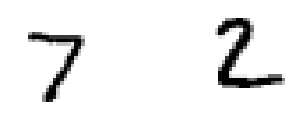

In [115]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Our input node expects to get data with shape (784,) so we need to reshape our two digits.

In [125]:
image_1 = x_test[0].ravel() / 255
image_2 = x_test[1].ravel() / 255

#### Prepare scoring payload and score.

In [127]:
scoring_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA : [
        {'values': [image_1.tolist(), image_2.tolist()]}
    ]
}
scores = client.deployments.score(ddl_deployment_uid, meta_props=scoring_payload)
print("Scoring result:\n" + json.dumps(scores, indent=2))

Scoring result:
{
  "predictions": [
    {
      "id": "scores",
      "values": [
        [
          5.224858283996582,
          4.164975643157959,
          2.8182342052459717,
          2.2185347080230713,
          1.9722726345062256,
          0.08405725657939911,
          0.03885947912931442,
          -4.1697306632995605,
          -5.613151550292969,
          -8.410587310791016
        ],
        [
          6.215160369873047,
          4.331275939941406,
          3.4441375732421875,
          3.148566722869873,
          1.6128898859024048,
          1.4905816316604614,
          1.3541288375854492,
          -3.308743476867676,
          -5.988607406616211,
          -11.858990669250488
        ]
      ]
    },
    {
      "id": "classes",
      "values": [
        [
          "7",
          "0",
          "5",
          "9",
          "1",
          "6",
          "8",
          "3",
          "2",
          "4"
        ],
        [
          "0",
          "1",
       

<a id="clean"></a>
# 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
# 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `ibm-watson-machine-learning-client` to run experiments. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Jan Sołtysik**, Intern in Watson Machine Learning.

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.